# Случайные процессы. Прикладной поток
## Практическое задание 9* --- бейзлайн-решение

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import statsmodels.api as sm
import random
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import warnings
warnings.filterwarnings('ignore')

Загрузка таблицы продаж. Параметр `parse_dates=[3]` указывает на то, что в третьем столбце (с нуля) нужно распарсить даты.

In [3]:
train = pd.read_csv('./train_without_hms_formated.csv', sep='\t', parse_dates=[3])
train.head(5)

,TRANSACTIONID,ITEMID,PRICE,TRANSDATE
0,6,80275632.0,149.0,2016-02-26
1,10,80275632.0,149.0,2016-02-26
2,12,80088007.0,8.0,2016-02-26
3,13,80088007.0,8.0,2016-02-26
4,14,80088007.0,8.0,2016-02-26


Есть записи, где не указан номер товара

In [4]:
train.iloc[2195]

TRANSACTIONID                   2063
ITEMID                           NaN
PRICE                           3000
TRANSDATE        2016-04-17 00:00:00
Name: 2195, dtype: object

In [5]:
train["PRICE"].min(), train["PRICE"].max()

(-0.050000000000000003, 4000000.0)

Когда преобразовываем `ITEMID` к int, пропуск заменяется на какую-то хрень, в общем-то, не важно.

In [6]:
train['ITEMID'] = np.array(train['ITEMID'], dtype=int)
train.iloc[2195]

TRANSACTIONID                    2063
ITEMID           -9223372036854775808
PRICE                            3000
TRANSDATE         2016-04-17 00:00:00
Name: 2195, dtype: object

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6398799 entries, 0 to 6398798
Data columns (total 4 columns):
TRANSACTIONID    int64
ITEMID           int64
PRICE            float64
TRANSDATE        datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 195.3 MB


Товары, продажи которых нужно предсказать

In [8]:
items_for_predictions = [80090775, 80088007, 80021669, 80018235, 80100848, 
                         80018236, 80007817, 80100859, 80073968, 80071318, 
                         80101583, 80100849, 80074450, 80100860, 80049805, 
                         80106282, 80101584, 80258337, 80105188, 80071390]

In [9]:
!cat items.csv

80007817
80018235
80018236
80021669
80049805
80071318
80071390
80073968
80074450
80088007
80090775
80100848
80100849
80100859
80100860
80101583
80101584
80105188
80106282
80258337


Составим для них временные ряды. Заметим так же, что теперь все товары упорядочены по возрастанию `ITEMID`, как и требуется.

In [10]:
# Найдем все строки таблицы, в которых указаны нужные нам товары
true_lines = np.in1d(train['ITEMID'], items_for_predictions)
# Оставим только их
train = train.iloc[true_lines]

# Таблица [дата, товар] -> количество проданного товара за день
timeseries = pd.crosstab(train['TRANSDATE'], train['ITEMID'])
timeseries

ITEMID,80007817,80018235,80018236,80021669,80049805,80071318,80071390,80073968,80074450,80088007,80090775,80100848,80100849,80100859,80100860,80101583,80101584,80105188,80106282,80258337
TRANSDATE,,,,,,,,,,,,,,,,,,,,
2015-08-01,31,39,16,40,21,9,3,18,0,41,216,31,22,15,14,25,13,11,9,5
2015-08-02,40,35,11,59,14,13,0,26,0,61,241,30,21,21,10,28,43,10,2,2
2015-08-03,10,5,2,30,2,1,1,8,0,172,141,17,10,12,10,6,2,1,0,2
2015-08-04,12,17,9,37,6,3,0,5,0,195,229,10,8,3,3,16,6,5,6,1
2015-08-05,12,20,6,38,9,10,0,8,0,248,277,16,18,15,10,9,11,5,1,2
2015-08-06,18,14,13,18,12,2,0,10,1,243,255,13,12,7,4,14,17,8,3,0
2015-08-07,8,16,12,43,5,10,1,12,4,280,312,19,9,11,9,16,10,6,15,1
2015-08-08,33,28,16,59,18,15,7,20,4,510,534,52,30,20,15,34,27,12,4,0
2015-08-09,53,27,16,54,11,13,7,18,8,515,550,54,30,24,18,36,20,7,5,2


In [11]:
timeseries.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 304 entries, 2015-08-01 to 2016-05-31
Data columns (total 20 columns):
80007817    304 non-null int64
80018235    304 non-null int64
80018236    304 non-null int64
80021669    304 non-null int64
80049805    304 non-null int64
80071318    304 non-null int64
80071390    304 non-null int64
80073968    304 non-null int64
80074450    304 non-null int64
80088007    304 non-null int64
80090775    304 non-null int64
80100848    304 non-null int64
80100849    304 non-null int64
80100859    304 non-null int64
80100860    304 non-null int64
80101583    304 non-null int64
80101584    304 non-null int64
80105188    304 non-null int64
80106282    304 non-null int64
80258337    304 non-null int64
dtypes: int64(20)
memory usage: 49.9 KB


Изобразим все полученные временные ряды на графике. Видим, что среди данных 20 товаров есть 2 самых популярных товара, причем для них наблюдается "яма" в конце 2015 года.

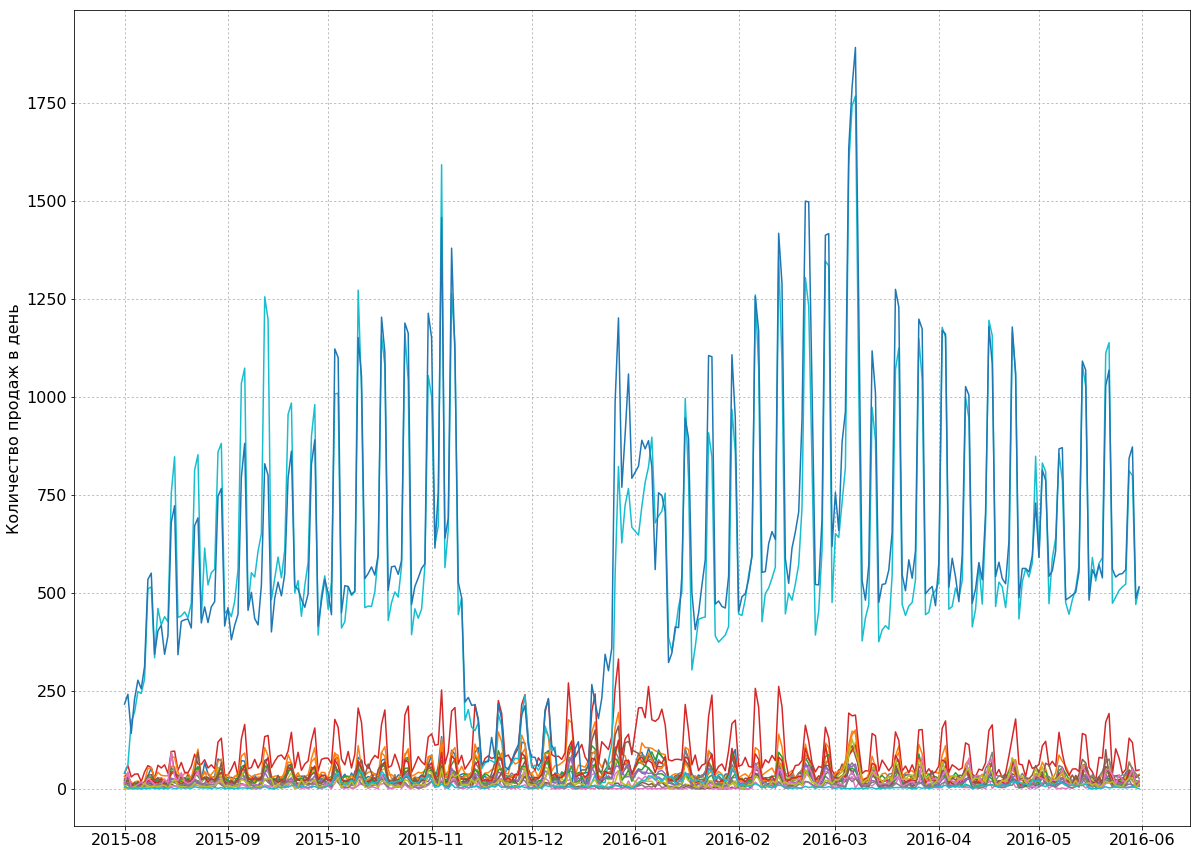

In [12]:
plt.figure(figsize=(20, 15))
plt.plot(timeseries)
plt.grid(ls=':')
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.ylabel('Количество продаж в день', fontsize=16)
plt.show()

Изобразим все временные ряды на графике еще раз, убрав два самых популярных товара.

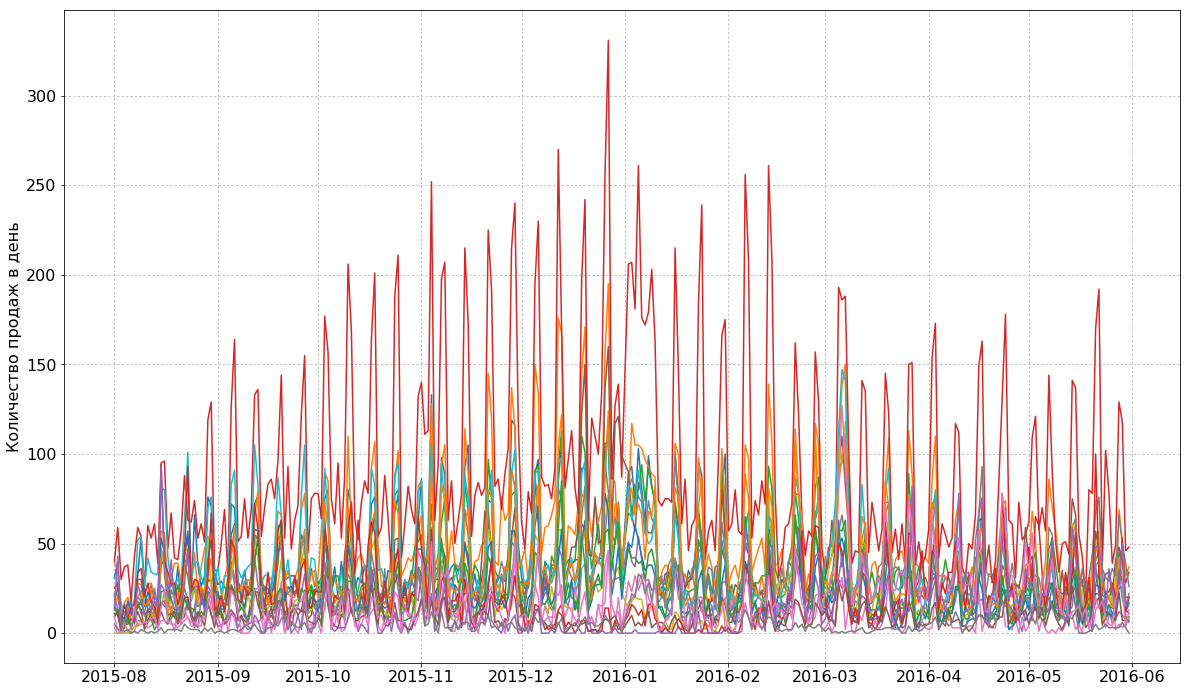

In [13]:
plt.figure(figsize=(20, 12))
plt.plot(timeseries.iloc[:, (np.arange(20) > 10) | (np.arange(20) < 9)])
plt.grid(ls=':')
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.ylabel('Количество продаж в день', fontsize=16)
plt.show()

In [14]:
# Эта функция вам уже встречалась в одном задании.
# Позволяем получать argmin в виде мультииндекса.
def cool_argmin(array):
    return np.unravel_index(np.argmin(array), array.shape)

Для каждого ряда переберем вручную кучу вариантов модели и выберем лучшую модель по AIC.

In [16]:
ps, ds, qs, Ps, Qs = 4, 2, 4, 4, 3  # количество параметров каждого типа для перебора
optim_params = []

aics = []
for i in tqdm_notebook(range(1)):  # цикл по товарам
    
    # временной ряд
    y = np.array(timeseries.iloc[:, i], dtype=float)
    
    aic_best =  10**10
    aic_params = None
    
    # Перебор параметров
    for p in tqdm_notebook([2, 3, 4], leave=False):
        for d in tqdm_notebook(range(ds + 1), leave=False):
            for q in tqdm_notebook(range(qs), leave=False):
                for P in tqdm_notebook([3, 4], leave=False):
                    for Q in tqdm_notebook(range(Qs), leave=False):
                        
                        try:
                            
                            # Задаем модель (период сезонности = 7, т.е. неделя)
                            model = sm.tsa.statespace.SARIMAX(y, order=(p, d, q), 
                                                              seasonal_order=(P+1, 1, Q+1, 7), 
                                                              enforce_stationarity=False, 
                                                              enforce_invertibility=False)
                            # Обучаем модель
                            model = model.fit()
                            
                            if aic_best > model.aic:
                                aic_best = model.aic
                                aic_params = (p, d, q, P, Q)
                                
                        # Если модель не рассчиталась, то пропускаем ее
                        except Exception:
                            pass
                        
    # Запоминаем параметры (индексы) у лучшей модели по AIC
    print("Best on ", i, ": [", aic_best, "] : ", aic_params)
    optim_params.append(aic_params)

Best on  0 : [ 2151.14959811 ] :  (4, 1, 1, 4, 0)



AttributeError: 'numpy.ndarray' object has no attribute 'append'

Значения AIC на последней итерации

In [71]:
aic

array([[[[[[  1.00000000e+10,   1.00000000e+10],
           [  1.00000000e+10,   1.00000000e+10]],

          [[  1.00000000e+10,   1.00000000e+10],
           [  1.00000000e+10,   1.00000000e+10]]],


         [[[  1.00000000e+10,   1.00000000e+10],
           [  1.00000000e+10,   1.00000000e+10]],

          [[  1.00000000e+10,   1.00000000e+10],
           [  1.00000000e+10,   1.00000000e+10]]],


         [[[  1.00000000e+10,   1.00000000e+10],
           [  1.00000000e+10,   1.00000000e+10]],

          [[  1.00000000e+10,   1.00000000e+10],
           [  1.00000000e+10,   1.00000000e+10]]],


         [[[  1.00000000e+10,   1.00000000e+10],
           [  1.00000000e+10,   1.00000000e+10]],

          [[  1.00000000e+10,   1.00000000e+10],
           [  1.00000000e+10,   1.00000000e+10]]]],



        [[[[  1.00000000e+10,   1.00000000e+10],
           [  1.00000000e+10,   1.00000000e+10]],

          [[  1.00000000e+10,   1.00000000e+10],
           [  1.00000000e+10,   1.0000000

Оптимальные параметры для каждого ряда

In [18]:

if True:
    optim_params = np.array([
       [4, 1, 1, 4, 0], #[3, 1, 2, 3, 0];; [ 2151.14959811 ] :  (4, 1, 1, 4, 0)
       [3, 1, 1, 3, 2],
       [3, 1, 1, 3, 2],
       [3, 1, 1, 3, 2],
       [3, 1, 1, 3, 2],
       [3, 1, 1, 3, 0],
       [3, 0, 0, 3, 2],
       [3, 0, 0, 3, 0],
       [3, 0, 1, 3, 2],
       [3, 1, 1, 3, 0],
       [3, 1, 1, 3, 0],
       [3, 1, 1, 3, 0],
       [3, 1, 1, 3, 0],
       [3, 1, 3, 3, 1],
       [3, 0, 2, 3, 0],
       [3, 1, 2, 3, 0],
       [3, 1, 1, 3, 0],
       [3, 0, 3, 3, 2],
       [3, 1, 1, 3, 2],
       [2, 1, 3, 3, 0]])
   
optim_params

array([[4, 1, 1, 4, 0],
       [3, 1, 1, 3, 2],
       [3, 1, 1, 3, 2],
       [3, 1, 1, 3, 2],
       [3, 1, 1, 3, 2],
       [3, 1, 1, 3, 0],
       [3, 0, 0, 3, 2],
       [3, 0, 0, 3, 0],
       [3, 0, 1, 3, 2],
       [3, 1, 1, 3, 0],
       [3, 1, 1, 3, 0],
       [3, 1, 1, 3, 0],
       [3, 1, 1, 3, 0],
       [3, 1, 3, 3, 1],
       [3, 0, 2, 3, 0],
       [3, 1, 2, 3, 0],
       [3, 1, 1, 3, 0],
       [3, 0, 3, 3, 2],
       [3, 1, 1, 3, 2],
       [2, 1, 3, 3, 0]])

Для каждого ряда снова обучаем оптимальную модель и строим прогнозы.

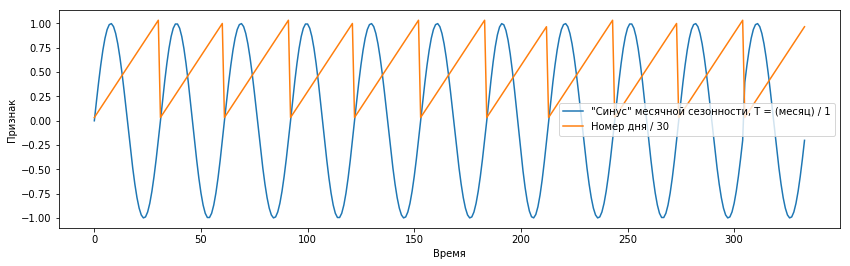

In [19]:
len_ds = len(timeseries.iloc[:, 0]) + 30 # длина прогноза

import datetime
from datetime import timedelta
d = datetime.date(2015, 8, 1) 
day = timedelta(days=1)

ms = []  # номера дней
for i in range(len_ds):
    ms.append((d + timedelta(days = i)).day)
ms = np.array(ms)

mss = [np.zeros_like(ms, dtype=float) for k in range(3)]
lastday = 0
T = 0
for i in range(len(ms) - 1):
    if ms[i] > ms[i + 1]:
        lastlastday = lastday
        lastday = i + 1
        T = ms[i]  # число замеров в месяце
        
        for k in range(3):
            rng = np.arange(T - (lastday - lastlastday),T) * (k + 1)  / T
            values = np.sin(rng * 2 * np.pi)
            mss[k][lastlastday:lastday] = values
       
        
lastlastday = lastday
lastday = len(ms)
for k in range(1):
    rng = np.arange(T - (lastday - lastlastday),T) * (k + 1)  / T
    values = np.sin(rng * 2 * np.pi)
    mss[k][lastlastday:lastday] = values

grid = np.arange(len(ms))
plt.figure(figsize=(14, 4))
for k in range(1):
    plt.plot(grid, mss[k],
             label="\"Синус\" месячной сезонности, T = (месяц) / %d" % (1+k))
plt.plot(grid, ms / 30, label = "Номер дня / 30")
plt.xlabel("Время")
plt.ylabel("Признак")
plt.legend()
plt.show()

In [20]:
len_ds = len(timeseries.iloc[:, 0]) + 30 # длина прогноза
# ! 152 - 31 декабря
timeseries.iloc[152:153, 0]

TRANSDATE
2015-12-31    33
Name: 80007817, dtype: int64

[364] True


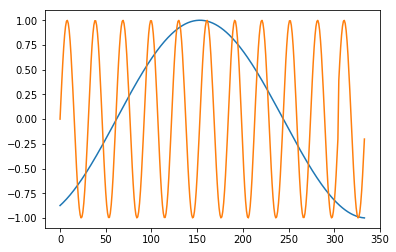

In [21]:
days = list(np.arange(365 - 153, 365))
days = np.array(days + list(np.arange(len_ds - len(days))))
print(days[152:153], len(days) == len_ds)
days = np.sin((days) / 365 * 2 * np.pi + np.pi / 2)

plt.plot(days)
plt.plot(mss[0])
plt.show()

In [22]:
divisor = 30
exog = np.vstack([mss[0], days]).T
exog_train, exog_test = exog[:-divisor], exog[-divisor:]
exog_train.shape, exog_test.shape

((304, 2), (30, 2))

In [23]:
np.random.seed(17)
random.seed(17)
forecast_len = 30  # горизонт прогнозирования
predicted = np.zeros((20, forecast_len))  # тут будут прогнозы

# цикл по товарам
for i in tqdm_notebook(range(20)):
    # временной ряд
    y = ystar = np.array(timeseries.iloc[:, i], dtype=float)
    if i in [9, 10]:
        y = y[170:]
        
    #y = ystar[1:] - ystar[:-1]
    # подобранные оптимальные параметры
    p, d, q, P, Q = optim_params[i]
    
    # Задаем модель.
    # Нужно ручное преобразование из numpy.in32 в int, иначе будет ошибка.
    model = sm.tsa.statespace.SARIMAX(y,
                                      order=(int(p), int(d), int(q)), 
                                      seasonal_order=(int(P) + 1, 1, int(Q) + 1, 7), 
                                      enforce_stationarity=False, enforce_invertibility=False)
    # Обучаем модель
    model = model.fit()
    # Считаем прогнозы
    pred = model.get_forecast(steps=forecast_len).predicted_mean
    """
    for k in range(len(pred)):
        if (k - 1) < 0:
            pred[k] += ystar[k - 1]
        else:
            pred[k] += pred[k - 1]
            """
    predicted[i] = pred

Результат записываем в файл

In [24]:
predicted[predicted < 0] = 0

In [25]:
t = pd.DataFrame(predicted.ravel())
t.columns = ['Count']
t.index.name = 'Id'
t.to_csv('ans.csv')

Дополнительно нужно заменить отрицательные числа на нули --- нельзя продать отрицательное число товара.

In [26]:
predicted.shape

(20, 30)

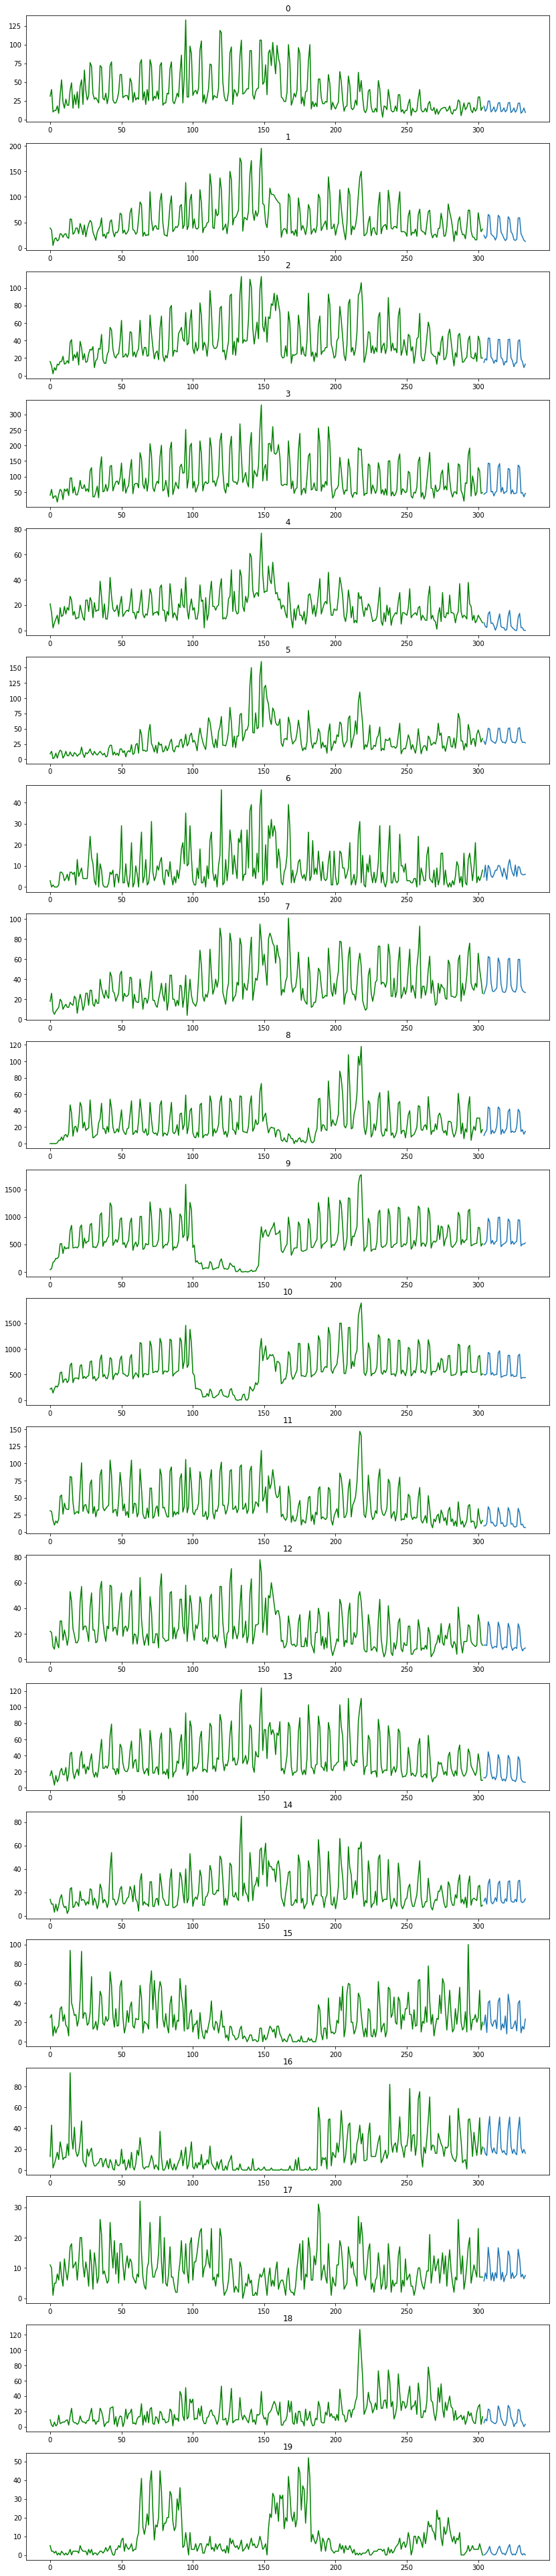

In [27]:
plt.figure(figsize=(14,70))
for i in range(20):
    plt.subplot(20, 1, i + 1)
    plt.title(str(i))
    values = np.array(timeseries.iloc[:, i], dtype=float)
    grid = np.arange(len(values) + forecast_len)
    plt.plot(grid[:-forecast_len], values, color="green")
    plt.plot(grid[-forecast_len:], predicted[i])
plt.show()

__________________

In [30]:
we = []
with open("weekends.txt") as f:
    for line in f:
        we.append(line[:-1])
print(we)

['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08', '2016-01-09', '2016-01-10', '2016-01-16', '2016-01-17', '2016-01-23', '2016-01-24', '2016-01-30', '2016-01-31', '2016-02-06', '2016-02-07', '2016-02-13', '2016-02-14', '2016-02-21', '2016-02-22', '2016-02-23', '2016-02-27', '2016-02-28', '2016-03-05', '2016-03-06', '2016-03-07', '2016-03-08', '2016-03-12', '2016-03-13', '2016-03-19', '2016-03-20', '2016-03-26', '2016-03-27', '2016-04-02', '2016-04-03', '2016-04-09', '2016-04-10', '2016-04-16', '2016-04-17', '2016-04-23', '2016-04-24', '2016-04-30', '2016-05-01', '2016-05-02', '2016-05-03', '2016-05-07', '2016-05-08', '2016-05-09', '2016-05-14', '2016-05-15', '2016-05-21', '2016-05-22', '2016-05-28', '2016-05-29', '2016-06-04', '2016-06-05', '2016-06-11', '2016-06-12', '2016-06-13', '2016-06-18', '2016-06-19', '2016-06-25', '2016-06-26', '2016-07-02', '2016-07-03', '2016-07-09', '2016-07-10', '2016-07-16', '2016-07-17', '2016

In [29]:
i = 0
y = np.array(timeseries.iloc[:, i], dtype=float)

def slicer(y, L, R):
    df = pd.DataFrame();
    for i in range(len(y) + L):
        df[str(i)] = y[i: i + R - L]
    w = np.arange(len(y))
    for i in range(7):
        df["w" + str(i)] = 1 * ((w % 7) == i)